# Alpha Zero

Main differences from AlphaGo Zero:

* AlphaZero predicted value is an expectation of reward (-1, 0, 1). AlphaGo Zero predicted probability to win

* AlphaZero maintains a single neural network that is updated continually. AlphaGo Zero self-play games were generated by the best player from all previous iterations (which is replaced if a new model has 55% wins against best model)

Paper: [Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm](https://arxiv.org/pdf/1712.01815v1.pdf)

Env based on: https://pettingzoo.farama.org/environments/classic/connect_four/

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import defaultdict, Counter, deque
import torch
import copy
import datetime
import time
from torch.utils.tensorboard import SummaryWriter
import resource

import connect_four


def show_usage():
    usage=resource.getrusage(resource.RUSAGE_SELF)
    print(f"usertime={usage[0]} systime={usage[1]} mem={usage[2]/1024.0} mb")

In [21]:
class MySummaryWriter(SummaryWriter):
    """
    Wrapper around tensorboard to add points one by one
    """
    def __init__(self):
        super().__init__()
        self.points_cnt = Counter()

    def append_scalar(self, name, value):
        step = self.points_cnt[name]
        self.points_cnt[name] += 1
        self.add_scalar(name, value, step)


TENSORBOARD = MySummaryWriter()

# Show environment

In [3]:
def show():
    env = connect_four.ConnectFour()

    state, mask = env.reset()

    for step in range(50):
        I = np.where(mask == 1)[0]
        action = np.random.choice(I)

        state, mask, reward, done = env.step(action)

        print(step % 2, action, (reward, done, state.board.shape, mask))

        if done:
            env.render_ascii()
            break

show()

0 1 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 6 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 5 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 1 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 2 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 1 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 1 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 3 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 2 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 0 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 6 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 5 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 4 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
1 6 (0, False, (6, 7, 2), array([1, 1, 1, 1, 1, 1, 1], dtype=int32))
0 1 (0, False, (6, 7, 2), array([1

# Baseline agents

In [4]:
class RandomAgent:
    def get_action(self, state: connect_four.HashableState, action_mask):
        I = np.where(action_mask == 1)[0]
        action = np.random.choice(I)
        return action


class AlwaysLeftAgent:
    def get_action(self, state: connect_four.HashableState, action_mask):
        I = np.where(action_mask == 1)[0]
        return I[0]


class AlwaysRightAgent:
    def get_action(self, state: connect_four.HashableState, action_mask):
        I = np.where(action_mask == 1)[0]
        return I[-1]


def battle(env, agent0, agent1, n_games, n_max_steps):
    """
    Play `n_games` where each game is at most `n_max_steps` turns.
    Return counter of game results as array `[
        agent0  first turn and agent0 wins,
        agent0 second turn and agent0 wins,
        agent1  first turn and agent1 wins,
        agent1 second turn and agent1 wins,
        draws
    ]`
    """

    results = [0, 0, 0, 0, 0]
    agents = [agent0, agent1]

    for game in range(n_games):
        state, mask = env.reset()

        agent_id_first_turn = game % 2  # Switch sides every other game

        for step in range(n_max_steps):
            curr_player_idx = (agent_id_first_turn + step) % 2

            action = agents[curr_player_idx].get_action(state, mask)

            state, mask, reward, done = env.step(action)

            if done:
                if reward == 1:
                    # `curr_player_idx` wins!
                    if curr_player_idx == agent_id_first_turn:
                        results[curr_player_idx * 2] += 1       # player who moved first - wins

                    else:
                        results[curr_player_idx * 2 + 1] += 1   # player who moved second - wins

                else:   # draw
                    results[4] += 1

                break

    return results


def show_sample_agents_battle():
    env = connect_four.ConnectFour()

    for name0, agent0, name1, agent1 in [
        ("RandomA", RandomAgent(), "RandomB", RandomAgent()),
        ("Random", RandomAgent(), "AlwaysLeft", AlwaysLeftAgent()),
        ("Random", RandomAgent(), "AlwaysRight", AlwaysRightAgent()),
        ("AlwaysLeft", AlwaysLeftAgent(), "AlwaysRight", AlwaysRightAgent()),
    ]:
        battle_results = battle(env, agent0, agent1, n_games=1000, n_max_steps=50)
        print(f"{name0} vs {name1}:")
        print(f"   {name0}  first turn wins: {battle_results[0]}")
        print(f"   {name0} second turn wins: {battle_results[1]}")
        print(f"   {name1}  first turn wins: {battle_results[2]}")
        print(f"   {name1} second turn wins: {battle_results[3]}")
        print(f"                      draws: {battle_results[4]}")

show_sample_agents_battle()


RandomA vs RandomB:
   RandomA  first turn wins: 260
   RandomA second turn wins: 230
   RandomB  first turn wins: 270
   RandomB second turn wins: 238
                      draws: 2
Random vs AlwaysLeft:
   Random  first turn wins: 128
   Random second turn wins: 83
   AlwaysLeft  first turn wins: 417
   AlwaysLeft second turn wins: 372
                      draws: 0
Random vs AlwaysRight:
   Random  first turn wins: 105
   Random second turn wins: 88
   AlwaysRight  first turn wins: 412
   AlwaysRight second turn wins: 395
                      draws: 0
AlwaysLeft vs AlwaysRight:
   AlwaysLeft  first turn wins: 500
   AlwaysLeft second turn wins: 0
   AlwaysRight  first turn wins: 500
   AlwaysRight second turn wins: 0
                      draws: 0


# Alpha Zero plays Connect Four

## Experience replay

In [5]:
class ExperienceReplayEpisode:
    def __init__(self, first_state):
        self.states = [first_state]
        self.actions = []
        self.terminal_rewards = [0, 0]

    def on_action(self, action: int, reward: int, done: bool, next_state: connect_four.HashableState):
        if done:
            player_idx = self.states[-1].player_idx
            self.terminal_rewards[player_idx] = reward
            self.terminal_rewards[1 - player_idx] = -reward
        self.actions.append(action)
        self.states.append(next_state)


class ExperienceReplay:
    """
    Store played games history
    """
    def __init__(self, max_episodes):
        self.episodes = deque()
        self.max_episodes = max_episodes

    def on_reset(self, state: connect_four.HashableState):
        self.episodes.append(ExperienceReplayEpisode(state))
        while len(self.episodes) > self.max_episodes:
            self.episodes.popleft()

    def on_action(self, action: int, reward: int, done: bool, next_state: connect_four.HashableState):
        self.episodes[-1].on_action(action, reward, done, next_state)

    def clear(self):
        self.episodes.clear()

    def yield_training_tuples(self):
        for episode in self.episodes:
            for i in range(len(episode.actions)):
                state = episode.states[i]
                action = episode.actions[i]
                reward = episode.terminal_rewards[state.player_idx]
                yield state, action, reward

## NN Model

In [22]:
class AlphaGoZeroModel(torch.nn.Module):
    """
    Implement AlphaGo Zero model with two heads: for action probabilities and state value
    """
    def __init__(self) -> None:
        super().__init__()

        self.model_common = torch.nn.Sequential(   # input (B, 6, 7, 2)
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=1),  # -> (B, 16, 4, 3)
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),  # -> (B, 32, 2, 1)
            torch.nn.Flatten(),   # -> 64
            torch.nn.Linear(64, 42),
            torch.nn.ReLU(),
        )

        self.model_action_logits = torch.nn.Sequential(
            torch.nn.Linear(42, 7),
        )

        self.model_state_value = torch.nn.Sequential(
            torch.nn.Linear(42, 1),
        )

    def _rotate_board(self, state: connect_four.HashableState):
        """
        Make current player to have coins at `board[:, :, 0]`, and opponent at `board[:, :, 1]`
        """
        board = state.board
        if state.player_idx == 1:
            board = np.flip(board, axis=2).copy()
        return board

    def forward_common(self, board):
        board = torch.permute(board, (0, 3, 2, 1))
        common = self.model_common(board)
        return common

    def forward(self, board):
        common = self.forward_common(board)
        action_logits = self.model_action_logits(common)
        state_value = self.model_state_value(common)

        # action_logits.shape == (B, 7)
        # state_value.shape == (B, 1)
        return action_logits, state_value

    def get_p_v_single_state(self, state: connect_four.HashableState, need_p: bool, need_v: bool):
        board = self._rotate_board(state)
        board = torch.from_numpy(np.expand_dims(board, axis=0)).float()
        common = self.forward_common(board)

        action_logits, state_value = None, None

        if need_p:
            action_logits = self.model_action_logits(common)
            action_probs = torch.nn.functional.softmax(action_logits, dim=1)
            action_probs = action_probs.detach().cpu().numpy()[0, :]

        if need_v:
            state_value = self.model_state_value(common)
            state_value = state_value.detach().cpu().numpy()[0, 0]

        return action_probs, state_value

    def get_rollout_action(self, state: connect_four.HashableState, actions_mask):
        action_probs, _ = self.get_p_v_single_state(state, need_p=True, need_v=False)
        action_probs[actions_mask == 0] = -np.inf

        return np.argmax(action_probs)

    def go_train(self, tree, experience_replay, optimizer, batch_size):
        self.train()

        dataset = []
        for state, action, reward in experience_replay.yield_training_tuples():
            board = self._rotate_board(state)
            cnt_visits = tree.N_cnt_visits[state]
            probs = cnt_visits / np.sum(cnt_visits)

            dataset.append((board, probs, reward))
            dataset.append((board[:, ::-1, :].copy(), probs[::-1], reward))  # Horizontal flip

        TENSORBOARD.append_scalar('data len', len(dataset))

        np.random.shuffle(dataset)
        for bi in range(batch_size, len(dataset) + 1, batch_size):
            boards = np.zeros((batch_size, 6, 7, 2))
            actual_probs = np.zeros((batch_size, 7))
            actual_values = np.zeros((batch_size, 1))

            for bj, (board, probs, value) in enumerate(dataset[bi - batch_size : bi]):
                boards[bj, ...] = board
                actual_probs[bj, :] = probs
                actual_values[bj, 0] = value

            boards = torch.as_tensor(boards).float()
            # print(f"[go_train] boards {boards.shape} {boards.dtype}")   # (B, rows, cols, 2)

            actual_probs = torch.as_tensor(actual_probs).float()
            # print(f"[go_train] actual_probs {actual_probs.shape} {actual_probs.dtype}")  # (B, cols)

            actual_values = torch.as_tensor(actual_values).float()
            # print(f"[go_train] actual_values {actual_values.shape} {actual_values.dtype}")  # (B, 1)

            pred_action_logits, pred_state_value = self.forward(boards)
            # print(f"[go_train] pred_action_logits {pred_action_logits.shape} {pred_action_logits.dtype}")  # (B, cols)
            # print(f"[go_train] pred_state_value {pred_state_value.shape} {pred_state_value.dtype}")  # (B, 1)

            # for bj in range(batch_size):
            #     print()
            #     connect_four.ConnectFour.render_board_ascii(boards.detach().numpy()[bj, ...])
            #     print(f"actual_probs {actual_probs.detach().numpy()[bj, ...]}, actual_values {actual_values.detach().numpy()[bj, ...]}")
            #     print(f"pred_action_logits {pred_action_logits.detach().numpy()[bj, ...]}, pred_state_value {pred_state_value.detach().numpy()[bj, ...]}")

            states_loss = torch.nn.functional.mse_loss(pred_state_value, actual_values)
            action_loss = torch.nn.functional.cross_entropy(pred_action_logits, actual_probs)

            TENSORBOARD.append_scalar('states_loss', states_loss.item())
            TENSORBOARD.append_scalar('action_loss', action_loss.item())

            loss = states_loss + action_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()


class AlphaGoZeroAgent:
    """
    Trained agent which can play Connect Four game using `AlphaGoZeroModel` model
    """
    def __init__(self, model: AlphaGoZeroModel, n_evaluate_games: int, n_max_steps: int) -> None:
        self.n_evaluate_games = n_evaluate_games
        self.n_max_steps = n_max_steps
        self.random_agent = RandomAgent()
        self.model = model

    @torch.no_grad()
    def get_action(self, state: connect_four.HashableState, actions_mask):
        self.model.eval()
        return self.model.get_rollout_action(state, actions_mask)

    @torch.no_grad()
    def report_model_performance_against_random(self, env):
        """
        Play against random agent
        """
        self.model.eval()

        results = battle(env, self, self.random_agent, n_games=self.n_evaluate_games, n_max_steps=self.n_max_steps)

        wins = results[0] + results[1]
        losses = results[2] + results[3]

        print(f"  AlphaZero total wins {wins}, losses {losses}, draws {results[4]}. Detailed result: {results}")

        TENSORBOARD.append_scalar('wins against random', wins/self.n_evaluate_games)


## MCTS Tree

In [18]:
class MCTS_Tree:
    """
    Tree structure which keeps various statistics needed for MCTS
    """
    def __init__(self) -> None:
        # Structure of all dicts: { state -> [ action -> value ] }
        self.N_cnt_visits = dict()
        self.W_sum_vals = dict()
        self.Q_values = dict()
        self.P_action_probs = dict()

        self.V_state_values = dict()  # { state -> predicted state value v(s) }


    def get_action(self, state: connect_four.HashableState):
        N_s_a = self.N_cnt_visits[state]
        Q_s_a = self.Q_values[state]
        P_s_a = self.P_action_probs[state]
        U_s_a = 1 * P_s_a * (np.sqrt(np.sum(N_s_a)) + 1e-8) / (1 + N_s_a)
        action = np.argmax(Q_s_a + U_s_a)
        return action


    def add_terminal_node(self, state, terminal_value):
        self.V_state_values[state] = terminal_value


    def add_node(self, state, action_probs, state_value, actions_mask):
        actions_len = len(actions_mask)

        self.N_cnt_visits[state] = np.zeros(actions_len)

        self.W_sum_vals[state] = np.zeros(actions_len)

        q_vals = np.zeros(actions_len)
        q_vals[actions_mask == 0] = -np.inf
        self.Q_values[state] = q_vals

        self.P_action_probs[state] = action_probs

        self.V_state_values[state] = state_value


    def backpropagate(self, sa_array):
        # `sa_array`: selected path in tree [state0, action0, state1, action1, ..., stateL],

        leaf_state = sa_array[-1]
        leaf_player_idx = leaf_state.player_idx
        leaf_value = self.V_state_values[leaf_state]

        # print('---')
        # print(f"len {len(sa_array)}, leaf player {leaf_player_idx}, leaf val {leaf_value}")

        assert len(sa_array) % 2 == 1
        for si in range(0, len(sa_array) - 1, 2):
            state, action = sa_array[si], sa_array[si + 1]

            curr_value = leaf_value if state.player_idx == leaf_player_idx else (-leaf_value)

            self.N_cnt_visits[state][action] += 1
            self.W_sum_vals[state][action] += curr_value
            self.Q_values[state][action] = self.W_sum_vals[state][action] / self.N_cnt_visits[state][action]

            # connect_four.ConnectFour.render_board_ascii(state.board)
            # print(f"player {state.player_idx}, action {action}, curr_value {curr_value}")
            # print(self.N_cnt_visits[state], self.Q_values[state])
            # print()


    def clear(self):
        self.N_cnt_visits.clear()
        self.W_sum_vals.clear()
        self.Q_values.clear()
        self.P_action_probs.clear()
        self.V_state_values.clear()

## Model keeper

In [8]:
class ModelKeeper:
    """
    Save/load models from checkpoints
    """

    def __init__(self, best_model=None) -> None:
        self.best_model = best_model if best_model is not None else AlphaGoZeroModel()

    def clone_best_model(self):
        new_model = AlphaGoZeroModel()
        new_model.load_state_dict(copy.deepcopy(self.best_model.state_dict()))
        return new_model

    def save_best_model_checkpoint(self, optimizer: torch.optim.Optimizer, log_prefix):
        data = {
            'model': self.best_model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        checkpoint_path = f"checkpoint_{ time.strftime('%Y%m%d-%H%M%S') }.ckpt"
        torch.save(data, checkpoint_path)
        print(f"{log_prefix}. Checkpoint saved to `{checkpoint_path}`")

    def load_from_checkpoint(self, checkpoint_path: str):
        data = torch.load(checkpoint_path)
        model = AlphaGoZeroModel()
        model.load_state_dict(data['model'])
        self.best_model = model

## Implementation

In [25]:
class AlphaGoZero_Impl:
    def __init__(self,
        env,
        model_keeper: ModelKeeper,
        model_agent: AlphaGoZeroAgent,
        mem_max_episodes: int,
        n_iterations: int,
        n_games_per_iteration: int,
        evaluate_every_iterations_cnt: int,
        simulations_cnt: int,
        learning_rate: float,
        weight_decay: float,
        batch_size: int,
        root_dirichlet_alpha: float,
        root_exploration_fraction: float,
        num_sampling_moves: int,
    ):
        """
        Parameters:
        env: connect four compatible environment
        model_keeper: save/load model from checkpoints
        model_agent: instance of `AlphaGoZeroAgent` which is used to periodically play game for reporting
        mem_max_episodes: how many episodes keep in experience replay
        n_iterations: total number of iterations to self-play for learning. One iteration consists of playing `n_games_per_iteration` games and one training pass
        n_games_per_iteration: number of games to self-play each iteration
        evaluate_every_iterations_cnt: how often to report performance against random agent
        simulations_cnt: how many MCTS simulations run in each game
        learning_rate: learning rate for model optimizer
        weight_decay: weight decay for model training loss
        batch_size: batch size for model training
        root_dirichlet_alpha: noise power at each root state for selection
        root_exploration_fraction: noise fraction added at each root state for selection
        num_sampling_moves: number of moves to use soft sample (remaining moves use argmax)
        """
        self.root_env = env
        self.model_keeper = model_keeper
        self.model_agent = model_agent
        self.n_iterations = n_iterations
        self.n_games_per_iteration = n_games_per_iteration
        self.evaluate_every_iterations_cnt = evaluate_every_iterations_cnt
        self.simulations_cnt = simulations_cnt
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.root_dirichlet_alpha = root_dirichlet_alpha
        self.root_exploration_fraction = root_exploration_fraction
        self.num_sampling_moves = num_sampling_moves
        self.tree = MCTS_Tree()
        self.experience_replay = ExperienceReplay(max_episodes=mem_max_episodes)

    def select(self, env):
        tree = self.tree
        state, actions_mask = env.last()
        sa_array = [state]    # selected path [state0, action0, state1, action1, ..., stateK],
        done = False
        reward = 0

        while sa_array[-1] in tree.V_state_values:
            action = tree.get_action(state)

            if actions_mask[action] == 0:
                print("N_cnt_visits", tree.N_cnt_visits[state])
                print("W_sum_vals", tree.W_sum_vals[state])
                print("Q_values", tree.Q_values[state])
                print("P_action_probs", tree.P_action_probs[state])
                print("V_state_values", tree.V_state_values[state])

            state, actions_mask, reward, done = env.step(action)

            sa_array.append(action)
            sa_array.append(state)
            if done:
                break

        # Guarantees:
        #    `sa_array[-1] not in tree.states_set`
        #    `actions_mask, reward, done` tied to `sa_array[-1]`
        #    `env` moves to state `sa_array[-1]`
        return sa_array, actions_mask, reward, done

    def expand(self, model: AlphaGoZeroModel, sa_array, actions_mask):
        new_leaf_state = sa_array[-1]

        action_probs, state_value = model.get_p_v_single_state(new_leaf_state, need_p=True, need_v=True)
        action_probs[actions_mask == 0] = 0
        action_probs /= np.sum(action_probs)

        # last state becomes a leaf node `S_L`
        # ?? Maybe immediately update its statistics after expand: https://ai.stackexchange.com/questions/25451/how-does-alphazeros-mcts-work-when-starting-from-the-root-node
        self.tree.add_node(new_leaf_state, action_probs, state_value, actions_mask)

    def mcts_step(self, root_env, model: AlphaGoZeroModel):
        tree = self.tree

        root_state, actions_mask = root_env.last()
        if root_state not in tree.V_state_values:
            self.expand(model, [root_state], actions_mask)

        noise = np.random.gamma(self.root_dirichlet_alpha, 1, len(actions_mask))
        frac = self.root_exploration_fraction
        tree.P_action_probs[root_state] = tree.P_action_probs[root_state] * (1 - frac) + noise * frac

        for si in range(self.simulations_cnt):
            env = root_env.copy()

            sa_array, actions_mask, reward, done = self.select(env)

            if done:
                # Here `reward` value belongs to a state previous to `sa_array[-1]`
                last_state_reward = -reward
                tree.add_terminal_node(sa_array[-1], last_state_reward)
            else:
                self.expand(model, sa_array, actions_mask)

            tree.backpropagate(sa_array)

        state, actions_mask = root_env.last()
        N_s_a = tree.N_cnt_visits[state]

        if np.sum(state.board) <= self.num_sampling_moves:
            N_s_a = np.sqrt(N_s_a)
            pi_probs = N_s_a / np.sum(N_s_a)
            pi_probs[actions_mask == 0] = 0
            pi_probs /= np.sum(pi_probs)
            return np.random.choice(len(actions_mask), p=pi_probs)

        else:
            return np.argmax(N_s_a)

    def collect_statistics_using_self_play(self, model: AlphaGoZeroModel):
        experience_replay = self.experience_replay
        root_env = self.root_env

        for game_i in range(self.n_games_per_iteration):
            state, mask = root_env.reset()
            experience_replay.on_reset(state)
            while True:
                action = self.mcts_step(root_env, model)
                state, mask, reward, done = root_env.step(action)
                experience_replay.on_action(action, reward, done, state)
                if done:
                    break

    def go_train(self):
        model_keeper = self.model_keeper
        model_agent = self.model_agent
        experience_replay = self.experience_replay
        model = model_keeper.best_model

        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        for iter_i in range(self.n_iterations):
            self.tree.clear()
            experience_replay.clear()

            model.eval()
            with torch.no_grad():
                self.collect_statistics_using_self_play(model)

            model.train()
            model.go_train(self.tree, experience_replay, optimizer, self.batch_size)

            if (iter_i + 1) % self.evaluate_every_iterations_cnt == 0 or iter_i == self.n_iterations - 1:
                model.eval()
                model_keeper.save_best_model_checkpoint(optimizer, log_prefix=f"[{iter_i}/{self.n_iterations - 1}]")
                with torch.no_grad():
                    model_agent.report_model_performance_against_random(self.root_env)

def train_alphagozero_connectfour(model_keeper=None):
    env = connect_four.ConnectFour()

    if model_keeper is None:
        model_keeper = ModelKeeper()

    model_agent = AlphaGoZeroAgent(
        model_keeper.best_model,
        n_evaluate_games=400,
        n_max_steps=50)

    impl = AlphaGoZero_Impl(
        env=env,
        model_keeper=model_keeper,
        model_agent=model_agent,
        mem_max_episodes=100000,
        n_iterations=3000,
        n_games_per_iteration=10,
        evaluate_every_iterations_cnt=10,
        simulations_cnt=50,
        learning_rate=1e-3,
        weight_decay=1e-5,
        batch_size=8,
        root_dirichlet_alpha=0.3,  # chess value 0.3
        root_exploration_fraction=0.25,
        num_sampling_moves=7,
    )
    impl.go_train()

    return {
        'env': env,
        'model_keeper': model_keeper,
    }

# Go train

In [26]:
def load(checkpoint_path):
    model_keeper = ModelKeeper()
    model_keeper.load_from_checkpoint(checkpoint_path)
    return model_keeper

# training 3100 iters:
# trained = train_alphagozero_connectfour()
trained = train_alphagozero_connectfour(trained['model_keeper'])      # Continue existing training
# trained = train_alphagozero_connectfour(load('checkpoint_20240213-095815.ckpt'))  # Continue from checkpoint


[9/2999]. Checkpoint saved to `checkpoint_20240213-174452.ckpt`
  AlphaZero total wins 361, losses 39, draws 0. Detailed result: [196, 165, 35, 4, 0]
[19/2999]. Checkpoint saved to `checkpoint_20240213-174747.ckpt`
  AlphaZero total wins 295, losses 105, draws 0. Detailed result: [168, 127, 73, 32, 0]
[29/2999]. Checkpoint saved to `checkpoint_20240213-175059.ckpt`
  AlphaZero total wins 375, losses 25, draws 0. Detailed result: [194, 181, 19, 6, 0]
[39/2999]. Checkpoint saved to `checkpoint_20240213-175352.ckpt`
  AlphaZero total wins 353, losses 47, draws 0. Detailed result: [187, 166, 34, 13, 0]
[49/2999]. Checkpoint saved to `checkpoint_20240213-175729.ckpt`
  AlphaZero total wins 332, losses 68, draws 0. Detailed result: [187, 145, 55, 13, 0]
[59/2999]. Checkpoint saved to `checkpoint_20240213-180026.ckpt`
  AlphaZero total wins 324, losses 76, draws 0. Detailed result: [171, 153, 47, 29, 0]
[69/2999]. Checkpoint saved to `checkpoint_20240213-180353.ckpt`
  AlphaZero total wins 36

In [27]:
show_usage()

def show_trained_model_against_random(trained):
    env = trained['env']
    model_keeper = trained['model_keeper']
    agent = AlphaGoZeroAgent(
        model_keeper.best_model,
        n_evaluate_games=400,
        n_max_steps=50)

    model_keeper.best_model.eval()
    with torch.no_grad():
        print(battle(env, agent, RandomAgent(), n_games=1000, n_max_steps=50))

show_trained_model_against_random(trained)

usertime=510130.073527 systime=4125.165426 mem=588.953125 mb
[477, 462, 23, 14, 24]


Model trained for 3000 iterations

Trained model outperforms random agent:

If random agent moves first, trained model wins 477 games, loses 23, draws 0

If trained model moves first it wins 462 games, loses 14, draws 24

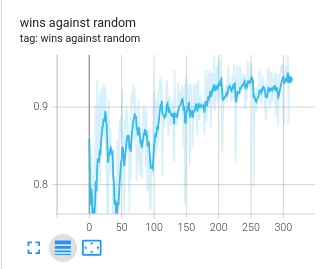

In [38]:
from IPython.display import Image
Image(filename='wins_against_random.png')

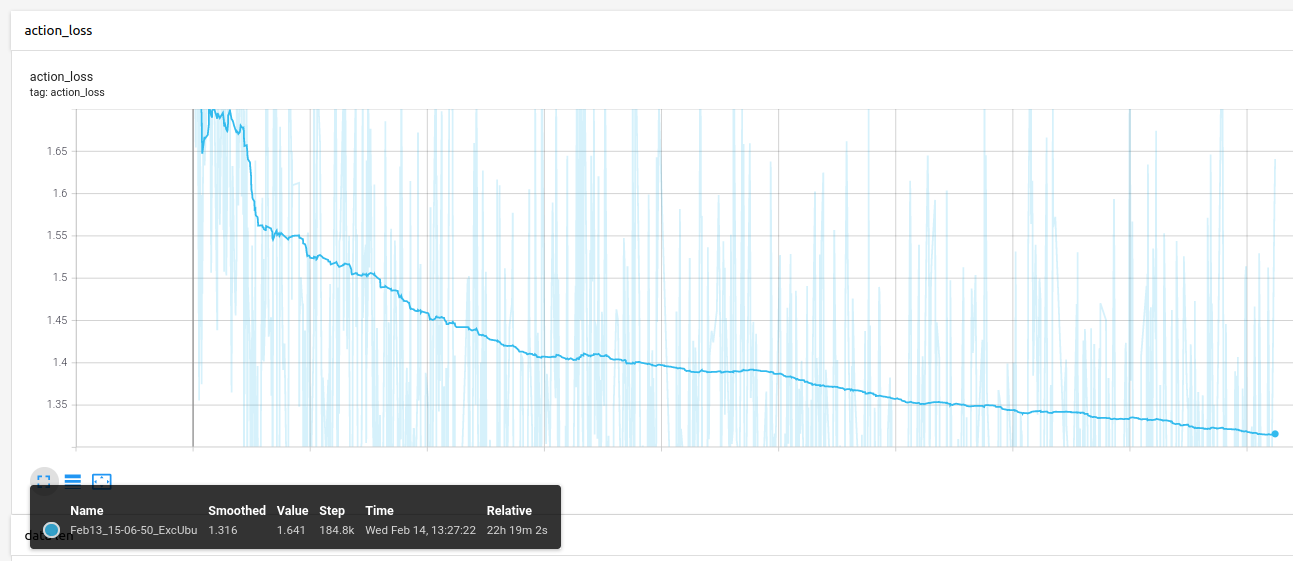

In [39]:
from IPython.display import Image
Image(filename='action_loss.png')

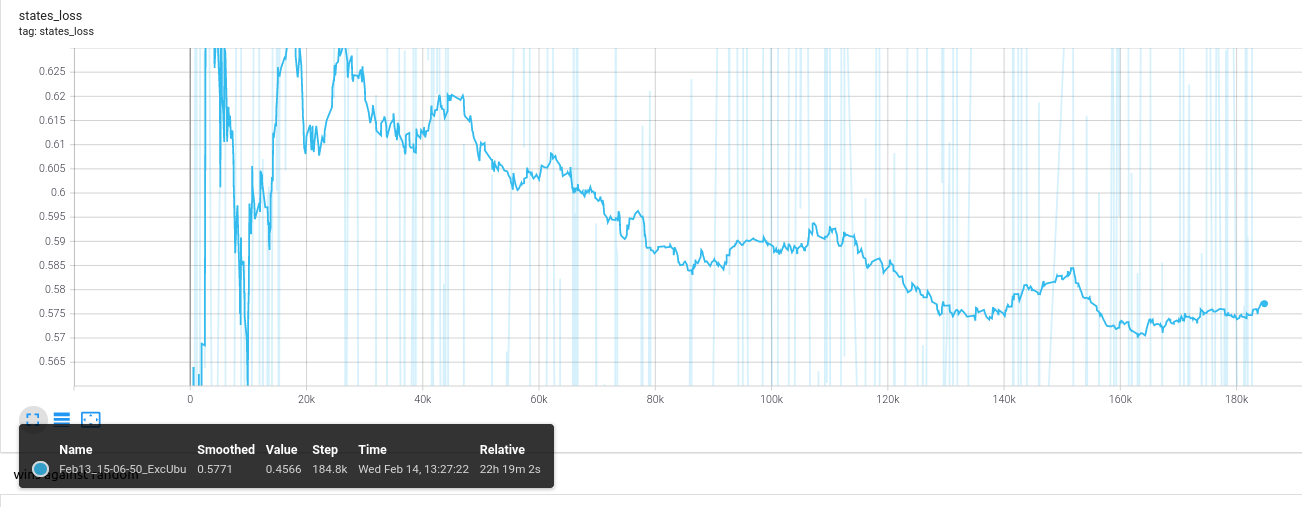

In [40]:
from IPython.display import Image
Image(filename='states_loss.png')

# Play

In [28]:
class Player:
    def __init__(self, trained):
        self.env = trained['env']
        self.model = trained['model_keeper'].best_model

    @torch.no_grad()
    def start_play_vs_ai(self, human_idx):
        env = self.env
        model = self.model
        model.eval()

        state, mask = env.reset()
        env.render_ascii()

        if human_idx > 0:
            self.ai_move()

    @torch.no_grad()
    def ai_move(self):
        env = self.env
        model = self.model
        model.eval()

        state, mask = env.last()
        action_probs, state_value = model.get_p_v_single_state(state, need_p=True, need_v=True)
        action = np.argmax(action_probs)
        print(f"Action probs: {list(action_probs)}, state value {state_value}")

        state, action_mask, reward, done = env.step(action)
        print()
        print(f"AI move {action}: actions mask {list(action_mask)}, reward {reward}, done {done}")
        env.render_ascii()

    @torch.no_grad()
    def human_move(self, action):
        env = self.env
        model = self.model
        model.eval()

        state, action_mask, reward, done = env.step(action)

        print()
        print(f"Your move {action}: actions mask {list(action_mask)}, reward {reward}, done {done}.")
        env.render_ascii()

        if not done:
            self.ai_move()

player = Player(trained)
player.start_play_vs_ai(human_idx=1)

.......
.......
.......
.......
.......
.......
Action probs: [0.02872769, 0.041407634, 0.21543828, 0.44969362, 0.19710812, 0.04051792, 0.027106741], state value 0.17205365002155304

AI move 3: actions mask [1, 1, 1, 1, 1, 1, 1], reward 0, done False
.......
.......
.......
.......
.......
...0...


In [37]:
player.human_move(4)


Your move 4: actions mask [1, 1, 1, 1, 1, 1, 1], reward 0, done False.
.......
..1....
.0001..
.1000..
.1010..
.11011.
Action probs: [0.06032374, 0.066802606, 0.19672044, 0.21638513, 0.18696253, 0.22515549, 0.04765015], state value 0.5763909816741943

AI move 5: actions mask [1, 1, 1, 1, 1, 1, 1], reward 0, done False
.......
..1....
.0001..
.1000..
.10100.
.11011.


In [14]:
# TODO:
# Cpuct: supplementary materials p5
# LR schedule: supplementary materials p7
# resignation threshold